# Sentiment Analysis on Tweets for Stocks

In [56]:
# Libraries
import twint
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import plotly.express as px
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Gathering Tweets

## Function for Twint

In [26]:
def getTweets(search_term, date, limit):
    """
    Configures Twint and returns a dataframe of the results.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Count of the number of tweets fetched
    c.Count = True

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True

    # Getting popular tweets
    c.Popular_tweets = True

    # Lowercasing tweets
    c.Lowercase = True

    # English only
    c.Lang ='en'

    # Excluding tweets with links
    c.Links ='exclude'

    # Tweets until a specified date
    c.Until = date

    # Making the results pandas friendly
    c.Pandas = True
    
    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)

    # Assigning the DF
    df = twint.storage.panda.Tweets_df
    
    # Returning nothing if there is no more tweets to scrape
    if len(df)<=0:
        return
    
    # Formatting the date
    df['date'] = df['date'].apply(lambda x: x.split(" ")[0])
    
    # Filtering out other cashtag mentions
    df = df[df['cashtags'].apply(lambda x: len(x)==1)]
    
    return df

## Using Twint
Tweet retrieval over a period of time.

In [192]:
def tweetByDay(start, end, df, search, limit=20):
    """
    Gathers a set amount of tweets daily between two dates and returns a dataframe.
    """
    # Finishing the recursive loop
    if start==end:
        return df
    
    # Appending the new set of tweets for the day
    df = df.append(getTweets(search, end, limit), ignore_index=True)
    
    # The new start date
    new_end = (datetime.strptime(end, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    
    print(new_end)
    
    # Running the function again
    return tweetByDay(start, new_end, df, search)

In [180]:
# Getting tweets daily
df = tweetByDay("2021-09-01", "2021-08-21", pd.DataFrame(), search="$BBIG", limit=20)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
2021-08-22
[+] Finished: Successfully collected 20 Tweets.
2021-08-23
[+] Finished: Successfully collected 20 Tweets.
2021-08-24
[+] Finished: Successfully collected 20 Tweets.
2021-08-25
[+] Finished: Successfully collected 38 Tweets.
2021-08-26
[+] Finished: Successfully collected 20 Tweets.
2021-08-27
[+] Finished: Successfully collected 20 Tweets.
2021-08-28
[+] Finished: Successfully collected 20 Tweets.
2021-08-29
[+] Finished: Successfully collected 20 Tweets.
2021-08-30
[+] Finished: Successfully collected 20 Tweets.
2021-08-31
[+] Finished: Successfully collected 20 Tweets.
2021-09-01


# Sentiment Analysis

## Sentiment Function

In [214]:
def getSentiment(df, measurement="compound"):
    """
    Given a DF of tweets, analyzes the tweets and returns a new DF
    of sentiment scores based on the given measurement.
    Accepted sentiment measurements: ["pos", "neg", "neu", "compound"]
    """

    # Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Getting the sentiment score
    df['sentiment_score'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)[measurement])

    # Creating a DF with the average sentiment score each day
    sent_df = df.groupby('date')['sentiment_score'].mean().reset_index()
    
    # Converting the dates to datetime
    sent_df['date'] = sent_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    
    return sent_df

getSentiment(df)

,date,sentiment_score
0,2021-08-21,0.348918
1,2021-08-22,0.200464
2,2021-08-23,-0.128144
3,2021-08-24,0.114731
4,2021-08-25,-0.110312
5,2021-08-26,0.273992
6,2021-08-27,0.177577
7,2021-08-28,0.166071
8,2021-08-29,0.270409
9,2021-08-30,0.021593


## Visualization

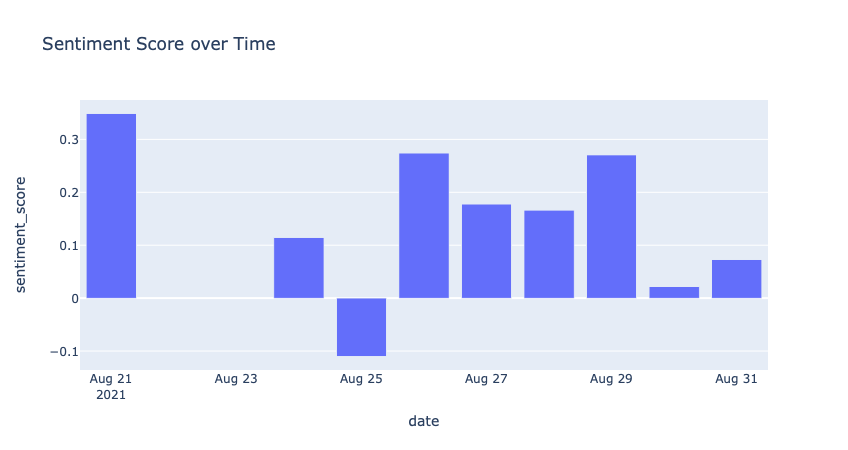

In [182]:
fig = px.bar(sent_df,
             x=sent_df['date'],
             y=sent_df['sentiment_score'],
             title="Sentiment Score over Time")

fig.show()

# Price Data

In [203]:
def getStockPrices(ticker, start, end, sent_low, sent_high):
    """
    Gets the historical daily prices between two dates. Scaling the prices based on a
    given sentiment dataframe.
    """
    # Setting the stock
    stock = yf.Ticker(ticker)

    # Getting historical prices
    stock_df = stock.history(start=end, end=start, interval="1d")[['Close']]

    # Scaling the data
    scaler = MinMaxScaler(
        feature_range=(sent_low, sent_high)
    )

    stock_df = pd.DataFrame(scaler.fit_transform(stock_df), 
                            columns=stock_df.columns, 
                            index=stock_df.index).reset_index().rename(columns={"Date": "date",
                                                                                "Close": "price (scaled)"})
    return stock_df

getStockPrices("BBIG", 
               "2021-09-01", 
               "2021-08-21", 
               sent_df['sentiment_score'].min(), 
               sent_df['sentiment_score'].max())

,date,price (scaled)
0,2021-08-23,-0.110312
1,2021-08-24,-0.071572
2,2021-08-25,-0.059466
3,2021-08-26,-0.072379
4,2021-08-27,0.118900
5,2021-08-30,0.260946
6,2021-08-31,0.348918


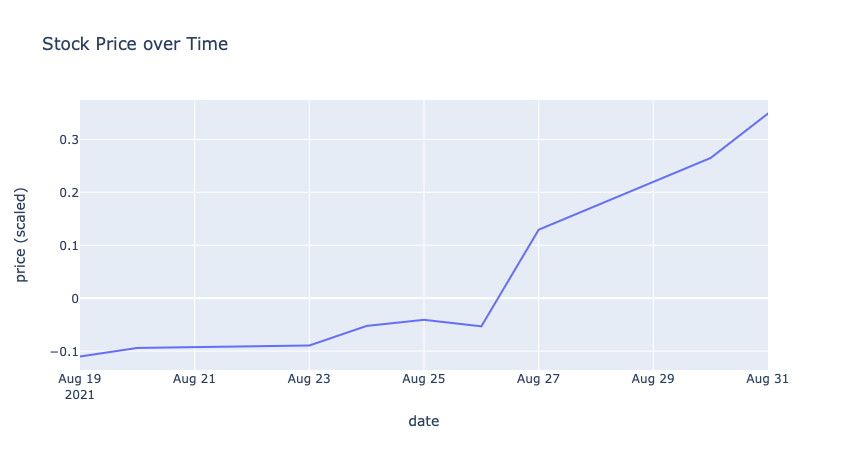

In [204]:
fig = px.line(stock_df,
             x=stock_df['date'],
             y=stock_df['price (scaled)'],
             title="Stock Price over Time")

fig.show()

# Price and Sentiment

In [189]:
# Merging the two DF
comb_df = sent_df.merge(stock_df, how='outer', sort=True)

# Filling in the price
comb_df['price (scaled)'] = comb_df['price (scaled)'].fillna(method='ffill')

In [190]:
comb_df

,date,sentiment_score,price (scaled)
0,2021-08-19,NaN,-0.110312
1,2021-08-20,NaN,-0.094131
2,2021-08-21,0.348918,-0.094131
3,2021-08-23,NaN,-0.089508
4,2021-08-24,0.114731,-0.052523
5,2021-08-25,-0.110312,-0.040965
6,2021-08-26,0.273992,-0.053293
7,2021-08-27,0.177577,0.129320
8,2021-08-28,0.166071,0.129320
9,2021-08-29,0.270409,0.129320


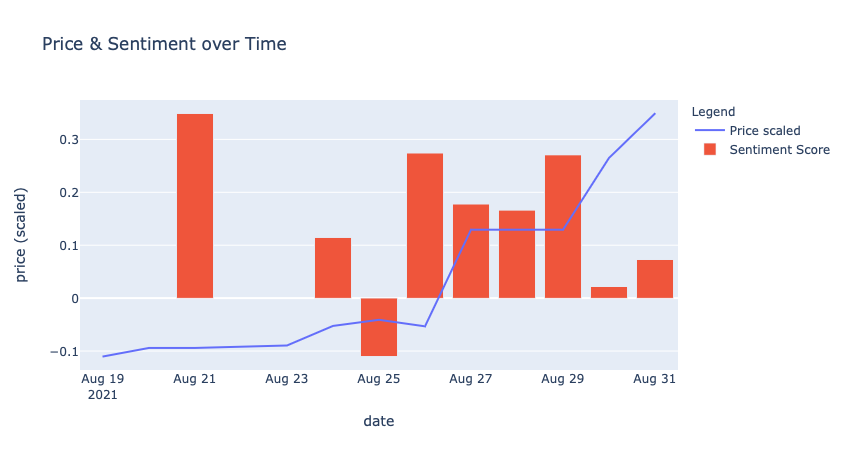

In [191]:
fig = px.line(comb_df,
              x=comb_df['date'],
              y=comb_df['price (scaled)'],
              title="Price & Sentiment over Time",
              color=px.Constant("Price scaled"),
              labels=dict(x="Price", y="Date", color="Legend"))
 
fig.add_bar(x=comb_df['date'],
            y=comb_df['sentiment_score'],
            name="Sentiment Score")

fig.show()

# Final Function

In [217]:
def sentimentAndPrice(ticker, start, end, numtweets=20):
    """
    Visually compares sentiment with the closing price of a given stock ticker.
    """
    # Creating a DF that contains daily tweets between two dates
    df = tweetByDay(start, end, pd.DataFrame(), search="$"+ticker, limit=numtweets)
    
    # Analyzing the sentiment of each tweet
    sent_df = getSentiment(
        df, 
        measurement='pos'
    )
    
    # Getting stock price history
    stock_df = getStockPrices(
        ticker, 
        start, 
        end, 
        sent_df['sentiment_score'].min(), 
        sent_df['sentiment_score'].max()
    )
    
    # Merging the two DF
    comb_df = sent_df.merge(stock_df, how='outer', sort=True)

    # Filling in the price
    comb_df['price (scaled)'] = comb_df['price (scaled)'].fillna(method='ffill')
    
    # Shifting the sentiment scores
    comb_df['sentiment_score'] = comb_df['sentiment_score'].shift(1)
    
    display(comb_df)
    
    # Visualizing the sentiment and price
    fig = px.line(comb_df,
              x=comb_df['date'],
              y=comb_df['price (scaled)'],
              title="Price & Sentiment over Time",
              color=px.Constant("Price scaled"),
              labels=dict(x="Price", y="Date", color="Legend"))
 
    fig.add_bar(x=comb_df['date'],
                y=comb_df['sentiment_score'],
                name="Sentiment Score")
    
    return fig.show()


[+] Finished: Successfully collected 20 Tweets.
2021-08-21
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
2021-08-22
[+] Finished: Successfully collected 37 Tweets.
2021-08-23
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
2021-08-24
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
2021-08-25
[+] Finished: Successfully collected 20 Tweets.
2021-08-26
[+] Finished: Successfully collected 20 Tweets.
2021-08-27
[+] Finished: Successfully collected 20 Tweets.
2021-08-28
[+] Finished: Successfully collected 20 Tweets.
2021-08-29
[+] Finished: Successfully collected 34 Tweets.
2021-08-30
[+] Finished: Successfully collected 20 Tweets.
2021-08-31
[+] Finished: Successfully collected 20 Tweets.
2021-09-01
[+] Finished: Successfully collected 20 Tweets.
2021

,date,sentiment_score,price (scaled)
0,2021-08-19,NaN,NaN
1,2021-08-20,0.090000,0.000000
2,2021-08-21,NaN,0.000000
3,2021-08-23,0.059000,0.077629
4,2021-08-24,NaN,0.084157
5,2021-08-25,0.048333,0.092236
6,2021-08-26,0.051333,0.062306
7,2021-08-27,0.000000,0.094382
8,2021-08-28,NaN,0.094382
9,2021-08-29,0.113429,0.094382


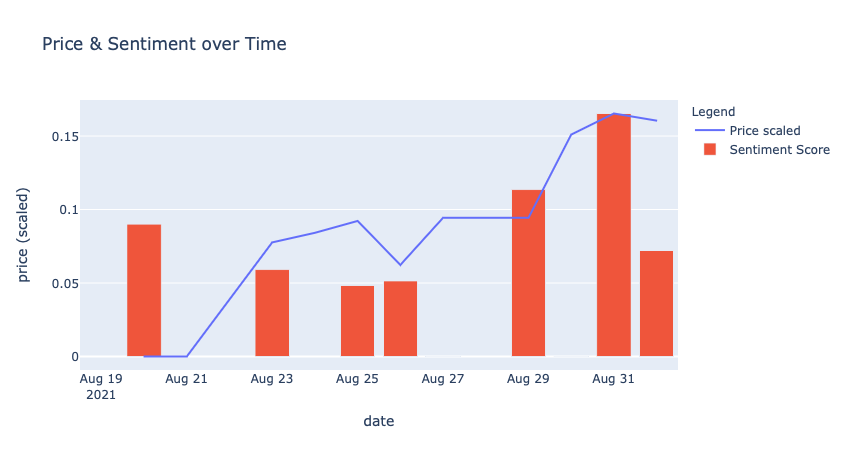

In [218]:
sentimentAndPrice("TSLA", "2021-09-02", "2021-08-20", numtweets=20)